In [1]:
#%matplotlib inline
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/MEPS/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval_MEPS/')
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import createFolder as cF
import calc_date as cd
import plot_sfc_spaghetti_ret as spagh
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import calc_48h_acc as acc
import fill_values as fv
import plot_vertical as pvert

import os

import pandas as pd
import matplotlib as mpl
mpl.style.use('ggplot')

from calc_diff_obs_model import *
from plt_spaghetti_scatter import *

In [2]:
year = 2016
month = 12
tid = '00'
station = 'Haukeliseter'
savefig = 0 # 1 = yes, 0 = no

In [3]:
#### days 
t = ['20', '21', '22', '23', '24', '25', '26', '27']


In [4]:
var = 'PP'
#var = 'SP'
#var = 'T2'
#var = 'WD'
#var = 'WS'
if var == 'PP':
    var_name = 'precipitation_amount_acc'
elif var == 'SP':
    var_name = 'air_pressure_at_sea_level'
elif var == 'T2':
    var_name = 'air_temperature_2m'
elif var == 'WD':
    var_name = 'wind_direction'
elif var == 'WS':
    var_name = 'wind_speed'


figdir_var = '../../Figures/MEPS/%s' %(var_name)
figdir_scatter = '../../Figures/MEPS/scatter_MEPS_obs/%s' %(var_name)
figdir_error = '../../Figures/MEPS/error/%s' %(var_name)
if savefig == 1:
    cF.createFolder('%s/' %(figdir_var))
    cF.createFolder('%s/' %(figdir_scatter))
    cF.createFolder('%s/' %(figdir_error))




form = 'png'

In [5]:
### MEPS
if var == 'SP' or var == 'PP':
    level = 'sfc'
elif var == 'T2':
    level = '2m'
elif var == 'WD' or var == 'WS':
    level = '10m'

ncdir_var = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)



################################################################
### Haukeli obs.
txtdir = '../../Data/eklima/'
txt_filename = 'Haukeli_obs_Dec2016'

In [6]:
# read in the Haukeliseter time file, sorted by daily values
Haukeli_Date = pd.read_csv('%s/Observations-Date-Hour.txt' %(txtdir),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')
DateHour = Haukeli_Date['Date-Hour(UTC)']

In [7]:
# read in the Haukeliseter observation file, sorted by daily values
Haukeli = pd.read_csv('%s/%s.txt' %(txtdir,txt_filename),\
                    sep = ';',header=18, skipfooter = 2, engine= 'python')

if var == 'PP':
    obsvar = Haukeli['RR_1'].astype(float)         # Precipitation (1 hour); [mm]
elif var == 'T2':
    obsvar = Haukeli['TA'].astype(float)           # Air temperature;degC --> Lufttemperatur ved observasjonstiden i 2 m høyde
elif var == 'SP':
    obsvar = Haukeli['PR'].astype(float)           # PR;Air pressure at sea level;hPa
elif var == 'WD' or var == 'WS':
    obsvar_DD = Haukeli['DD'].astype(float)             # Wind direction (FF); [degrees]
    obsvar_FF = Haukeli['FF'].astype(float)             # Wind speed (10 meters above ground);m/s

if var == 'PP' or var == 'T2' or var == 'SP':
    obsvar0, dt_obsvar0, hour_obsvar0, day_obsvar0, month_obsvar0, year_obsvar0 = obsDat.valid_values(obsvar, DateHour)
elif var == 'WD' or var == 'WS':
    idxFF = np.where(obsvar_FF[:] == -9999)
    idxDD = np.where(obsvar_DD[:] == -9999)

    obsvar_FF[idxFF[0][:]] = np.nan
    obsvar_DD[idxDD[0][:]] = np.nan

    ### calculate the U, V wind component for barb plot
    # http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html
    # first calculate the mathematical wind direction in deg
    md_deg = 270 - obsvar_DD
    for k in range(0,md_deg.shape[0]):
        if md_deg[k] <0 :
            md_deg[k] = md_deg[k] +360
    md_rad = math.pi/180. * md_deg
    uwind = obsvar_FF*np.cos(md_rad)
    vwind = obsvar_FF*np.sin(md_rad)
    
    obsvar_FF_wind, obsvar_DD_wind, \
            obsvar_dt_wind, obsvar_hour_wind, \
            obsvar_day_wind, obsvar_month_wind, \
            obsvar_year_wind = obsDat.valid_values_wind(obsvar_FF, obsvar_DD, DateHour)
    if var == 'WD':
        obsvar0 = obsvar_DD_wind
    elif var == 'WS':
        obsvar0 = obsvar_FF_wind

In [8]:
fn_var = dict()

if var == 'PP' or var == 'T2' or var == 'SP':
    model_var = dict()
elif var == 'WD' or var == 'WS':
    model_var_x = dict()
    model_var_y = dict()
    
    model_var = dict()


time_var      = dict()
lead_time_var = dict()
ini_day       = dict()
calday        = dict()
calmon        = dict()


In [9]:
calendar_day = []
initialisation_day = []
calendar_month = []
calendar_year = []
initialisation_hh = []

In [10]:
diff_var = dict()
Diff_var_0 = []
Diff_var_1 = []
Diff_var_2 = []
Diff_var_3 = []
Diff_var_4 = []
Diff_var_5 = []
Diff_var_6 = []
Diff_var_7 = []
Diff_var_8 = []
Diff_var_9 = []


all_day_max_var = []
all_day_min_var = []

In [11]:
model_var_0 = []
model_var_1 = []
model_var_2 = []
model_var_3 = []
model_var_4 = []
model_var_5 = []
model_var_6 = []
model_var_7 = []
model_var_8 = []
model_var_9 = []

obs_var = []

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


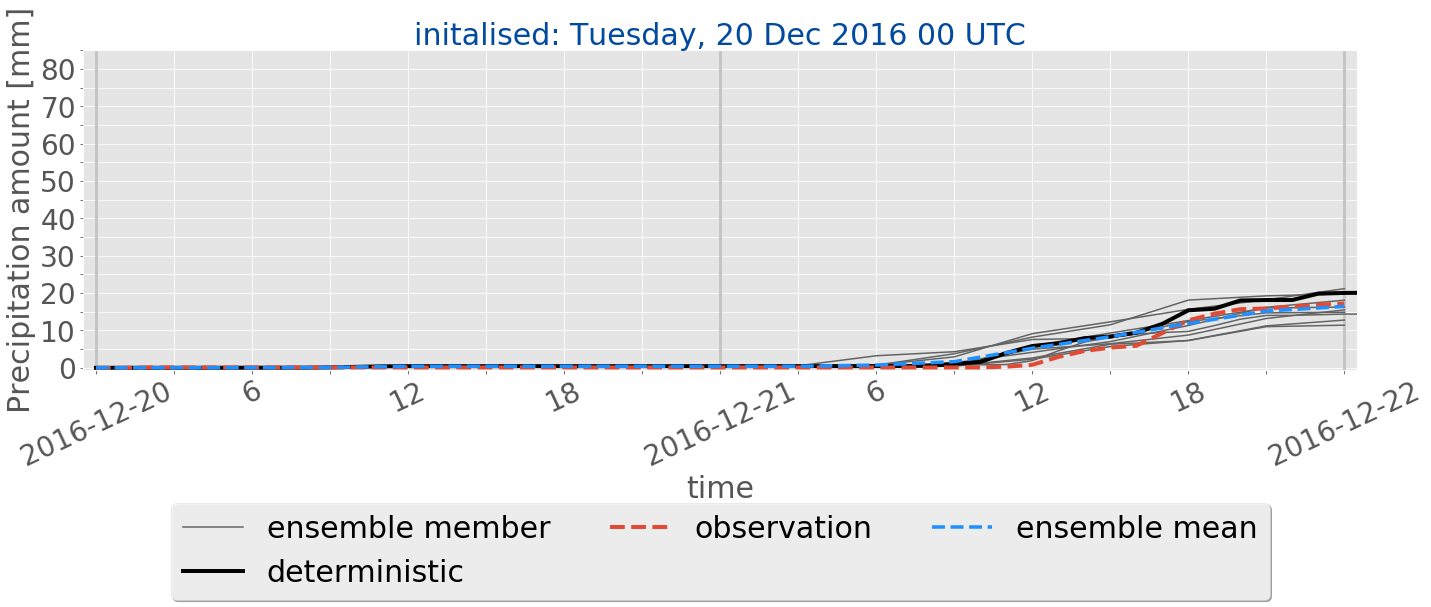

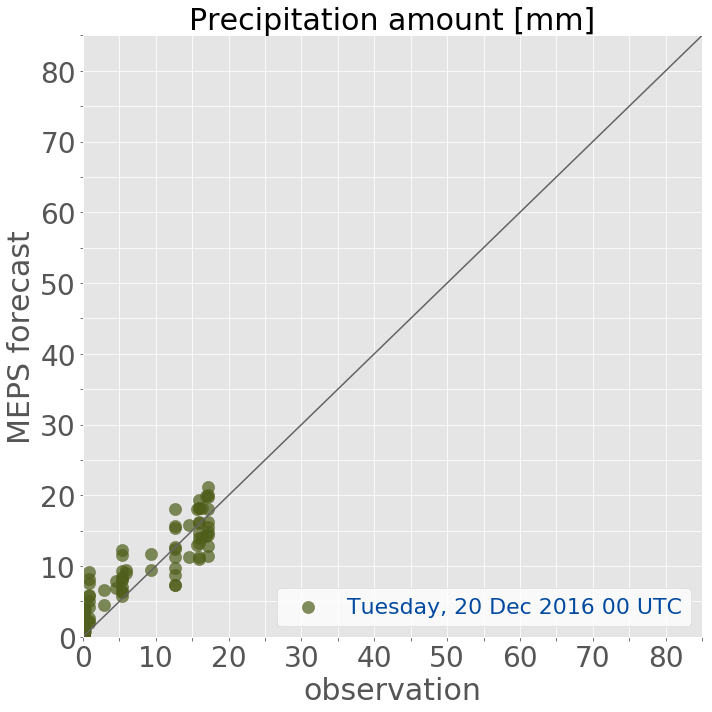

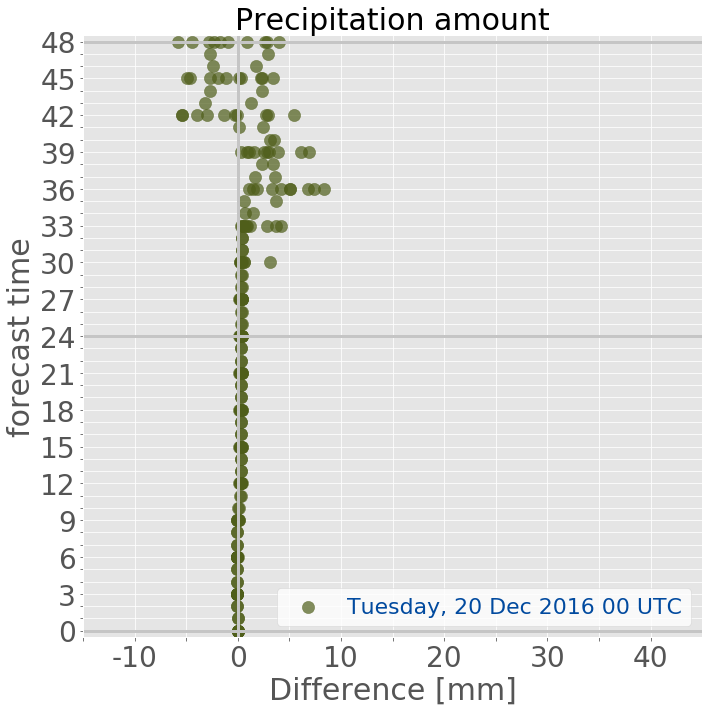

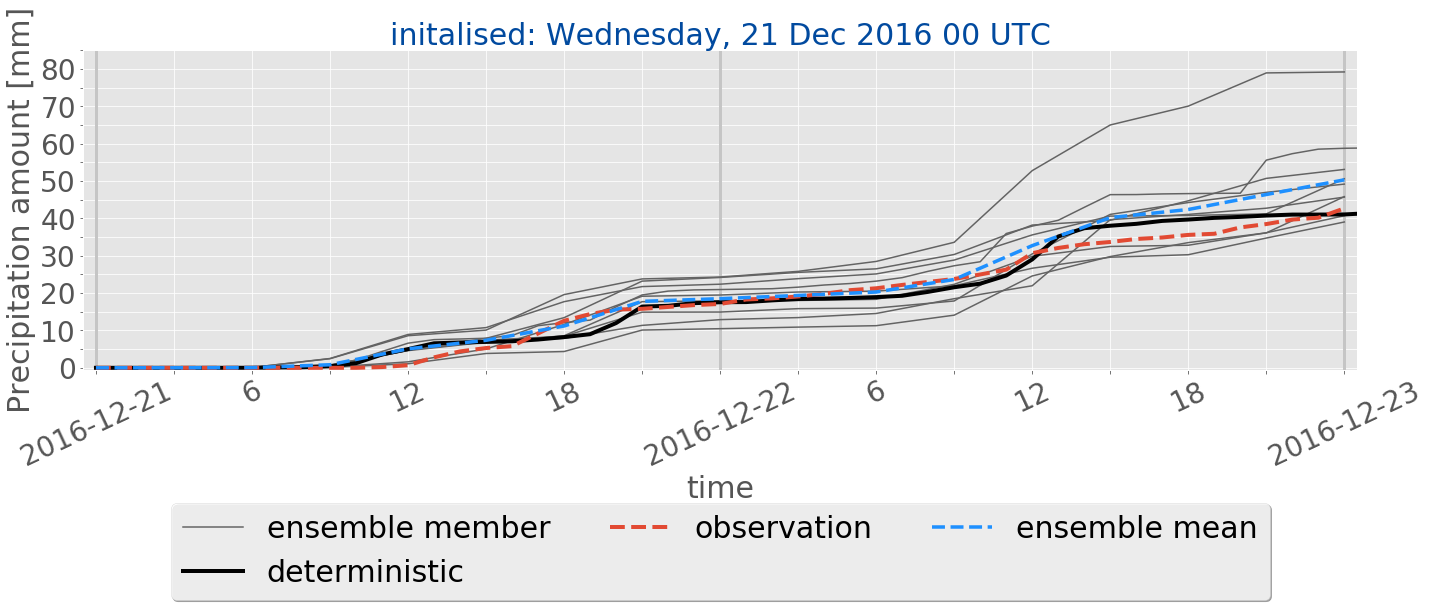

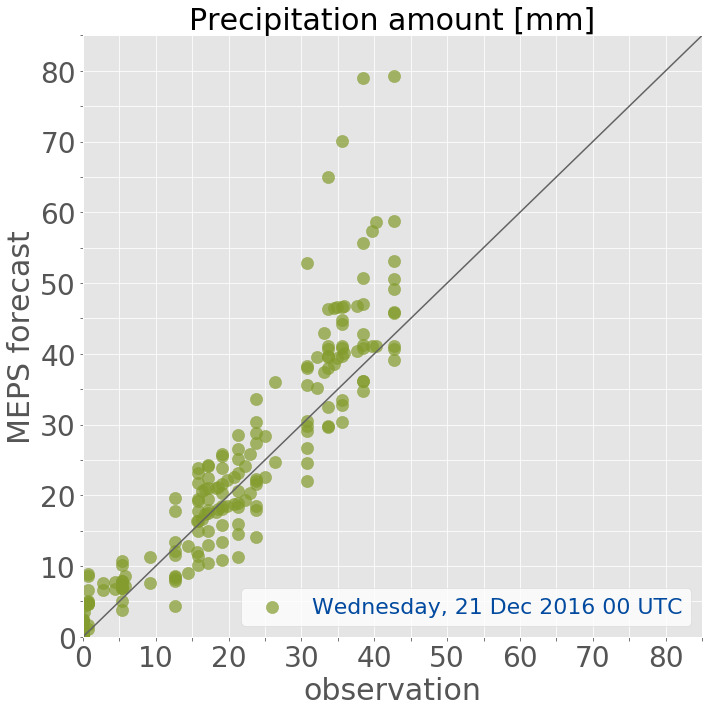

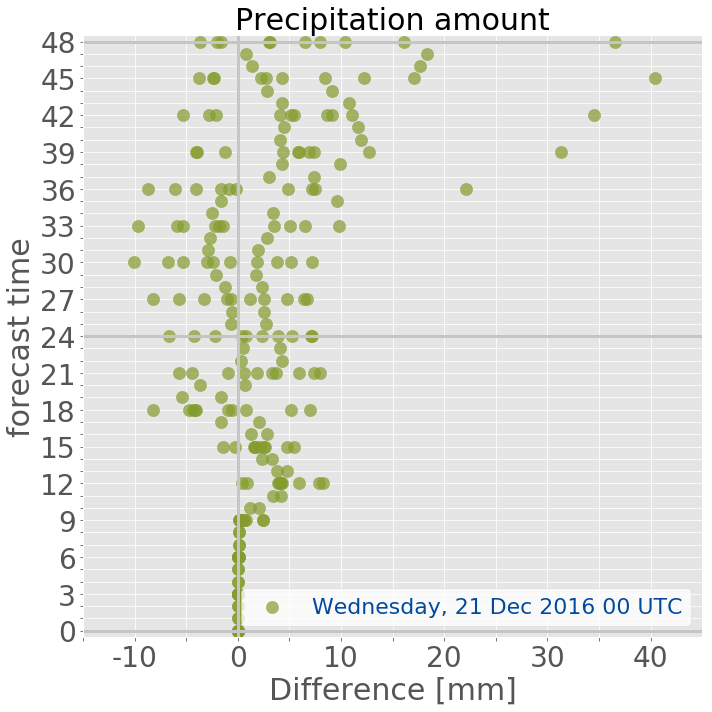

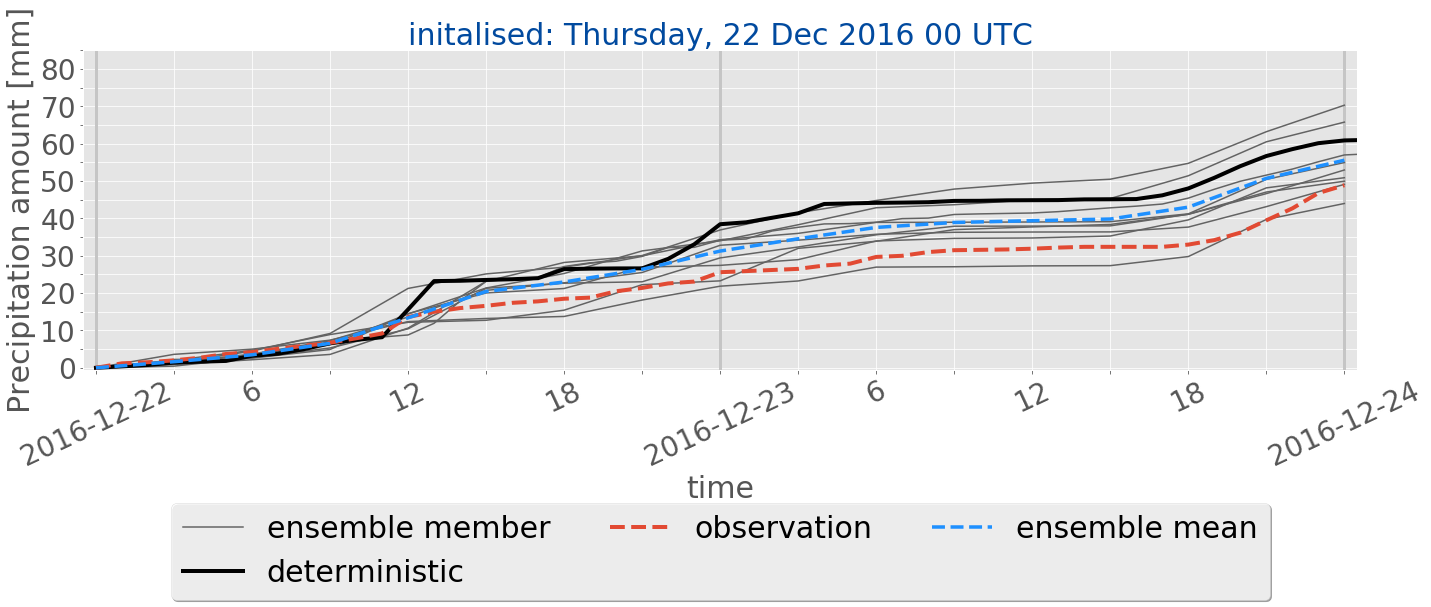

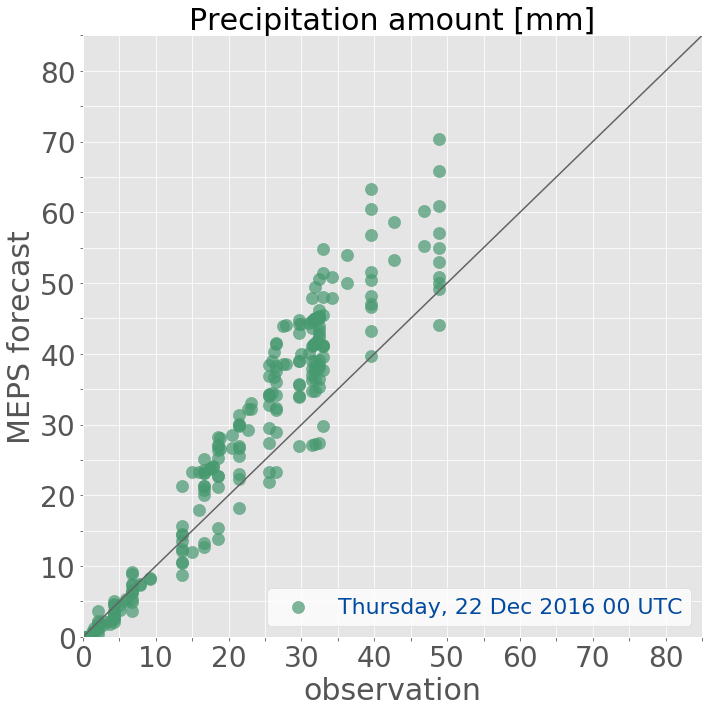

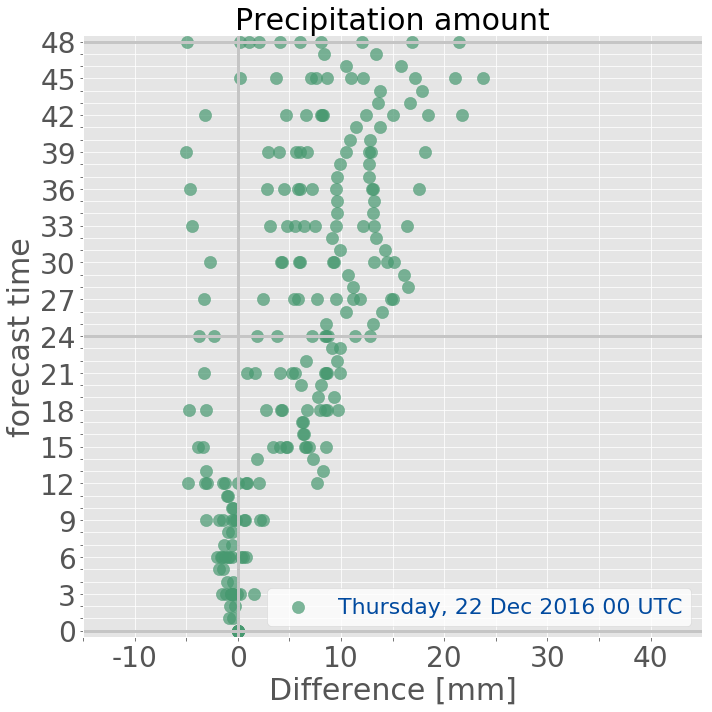

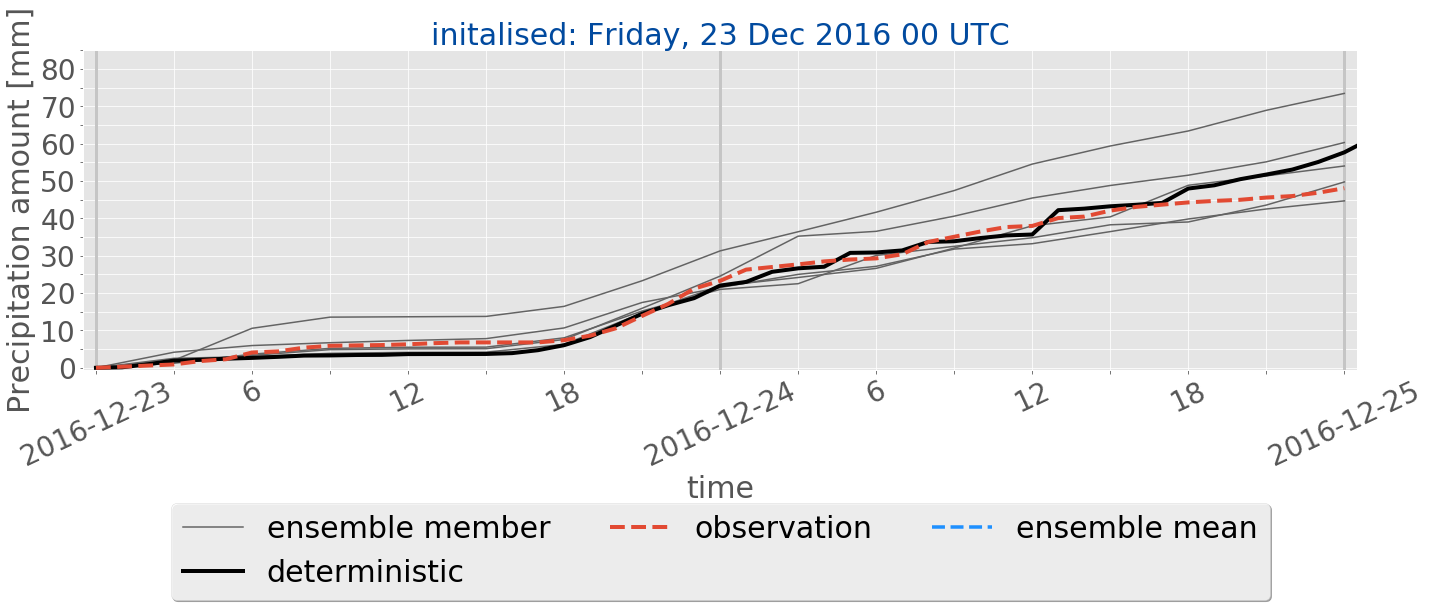

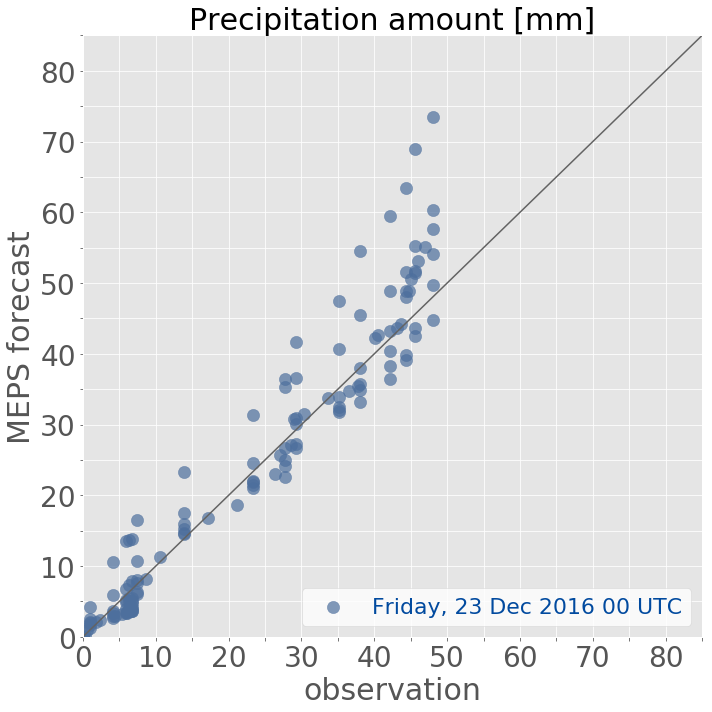

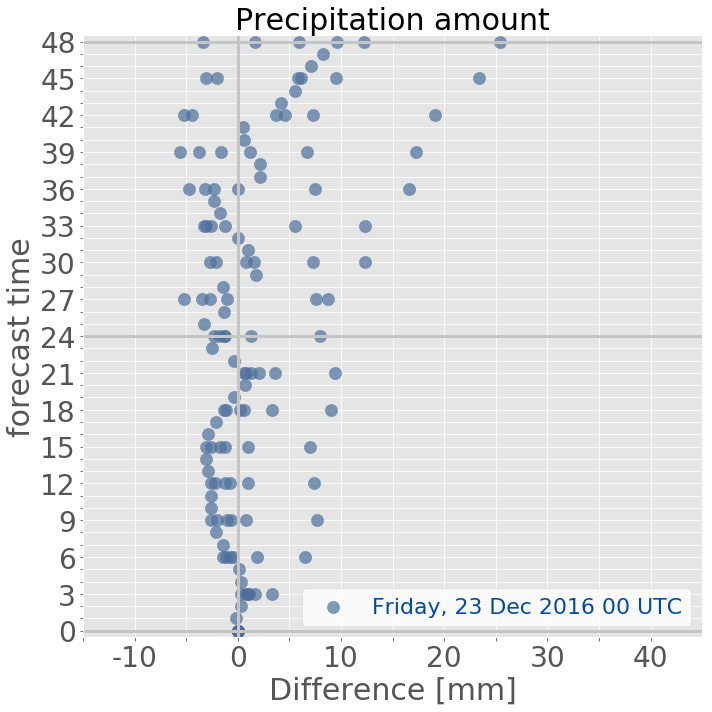

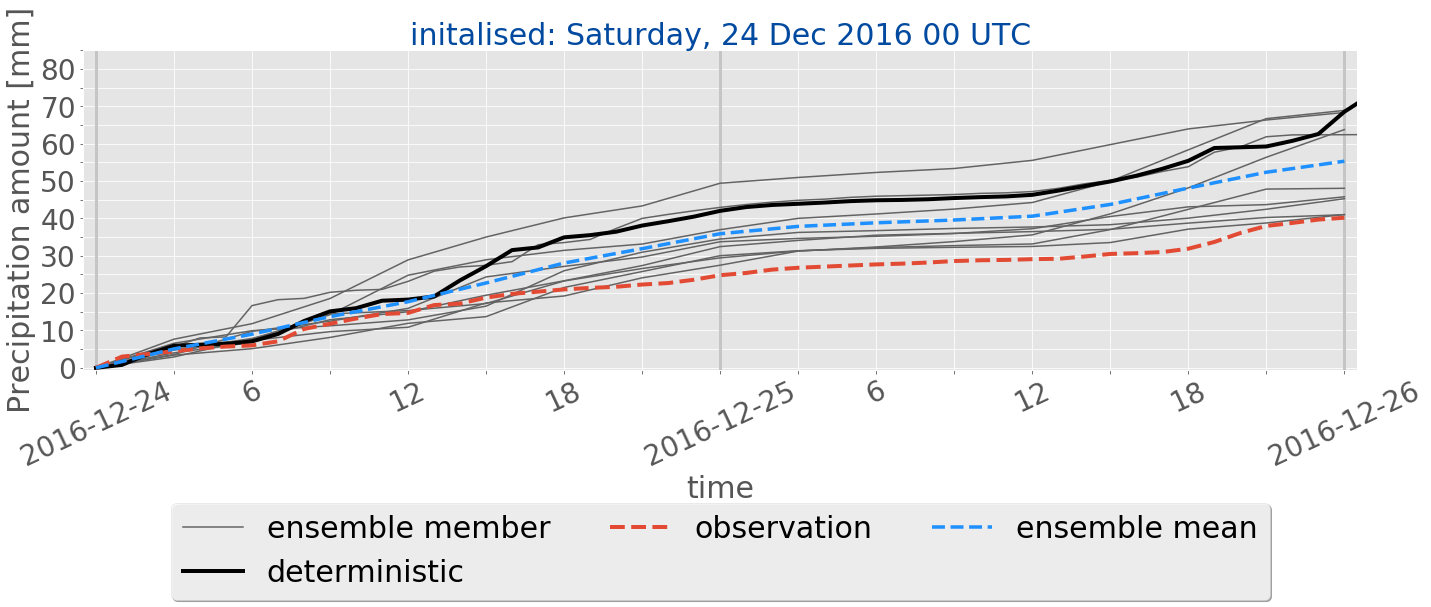

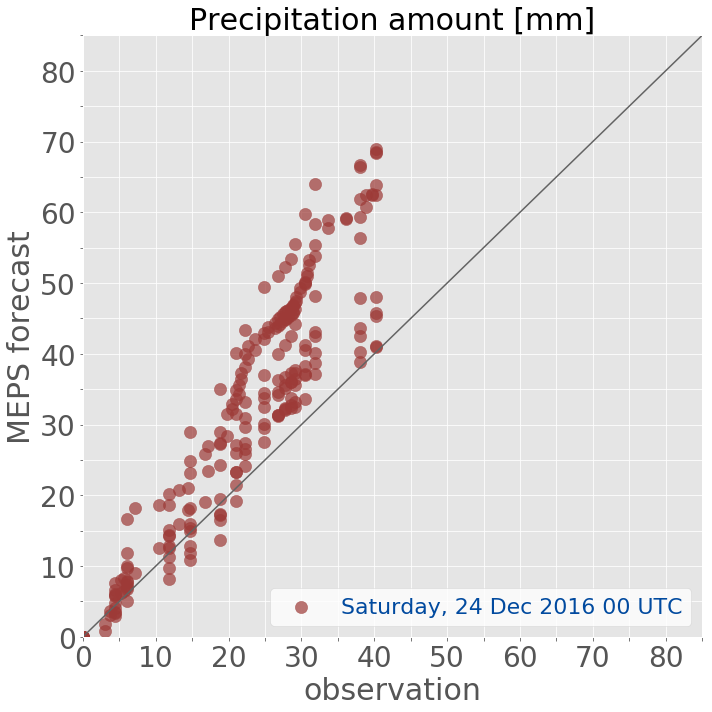

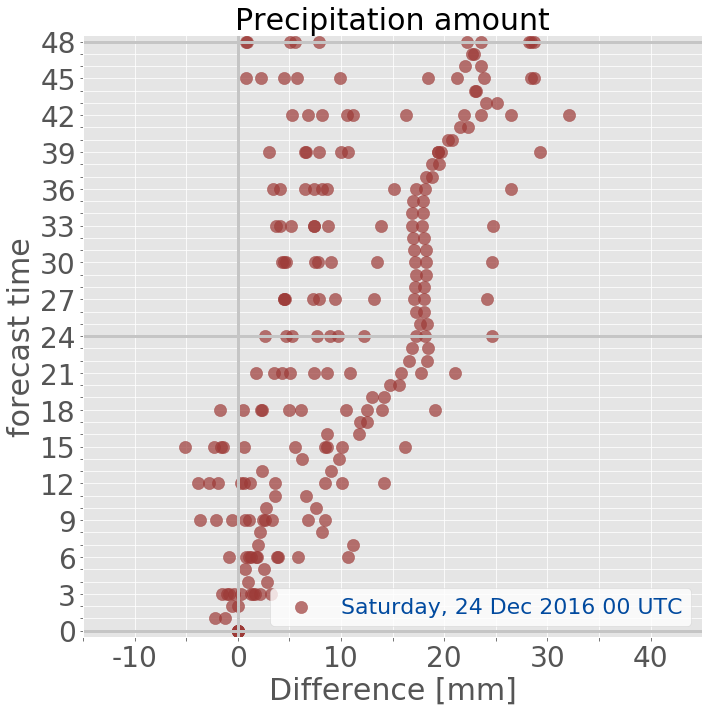

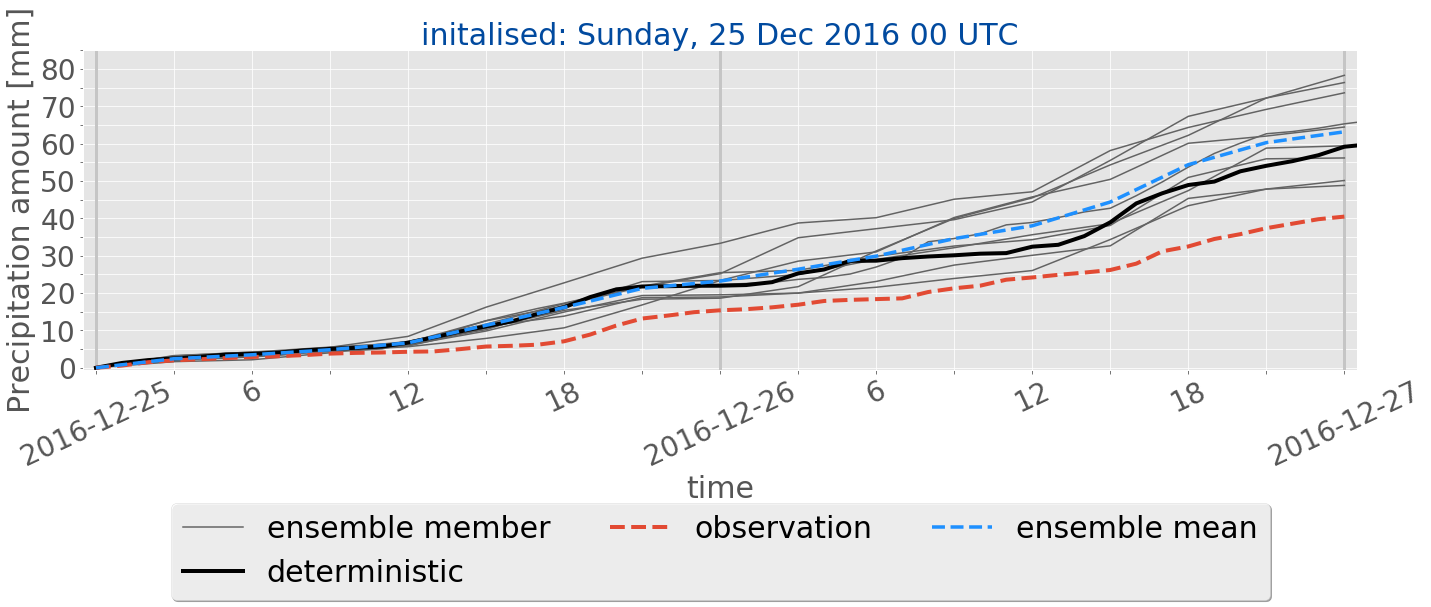

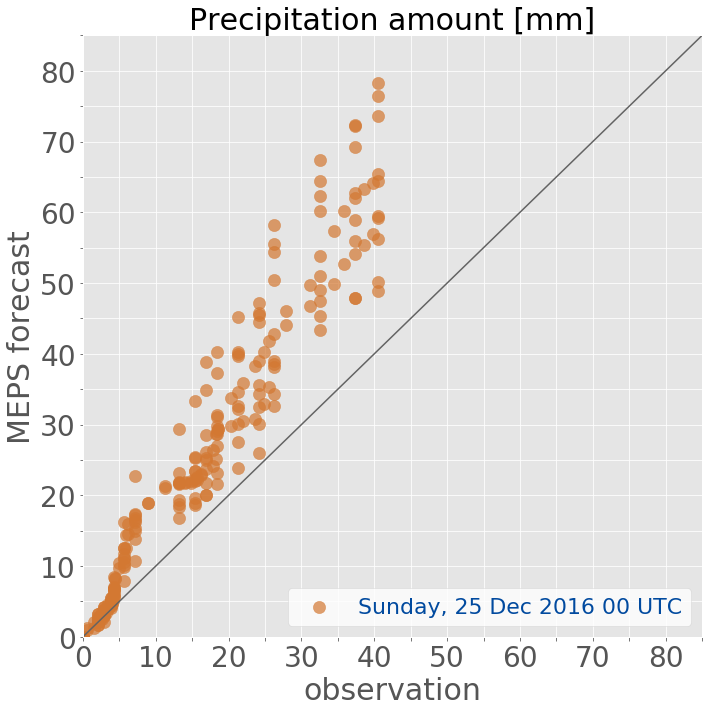

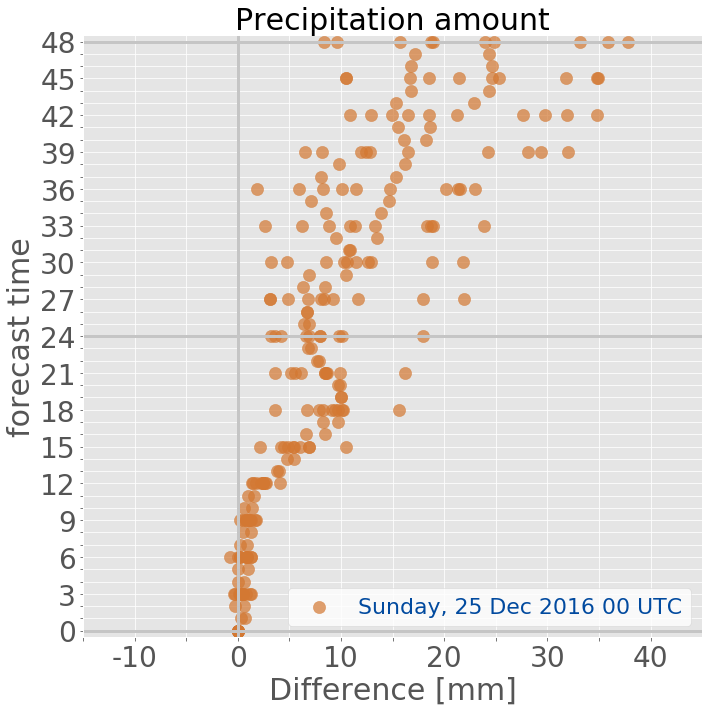

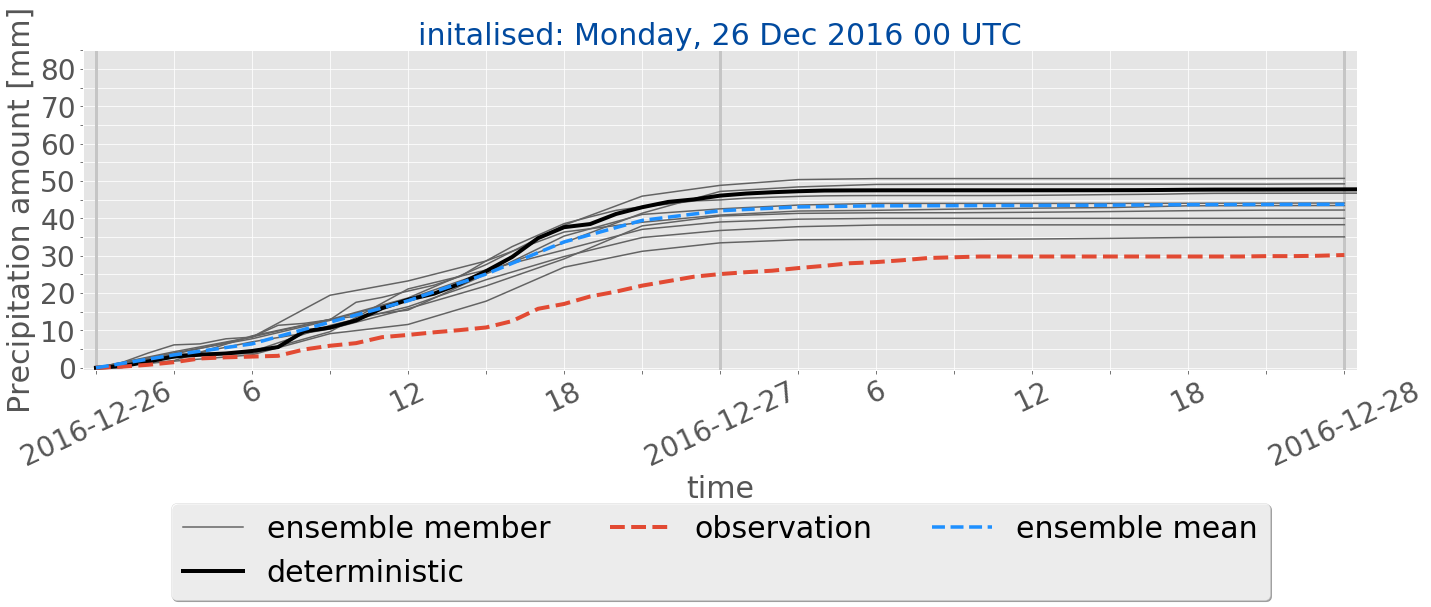

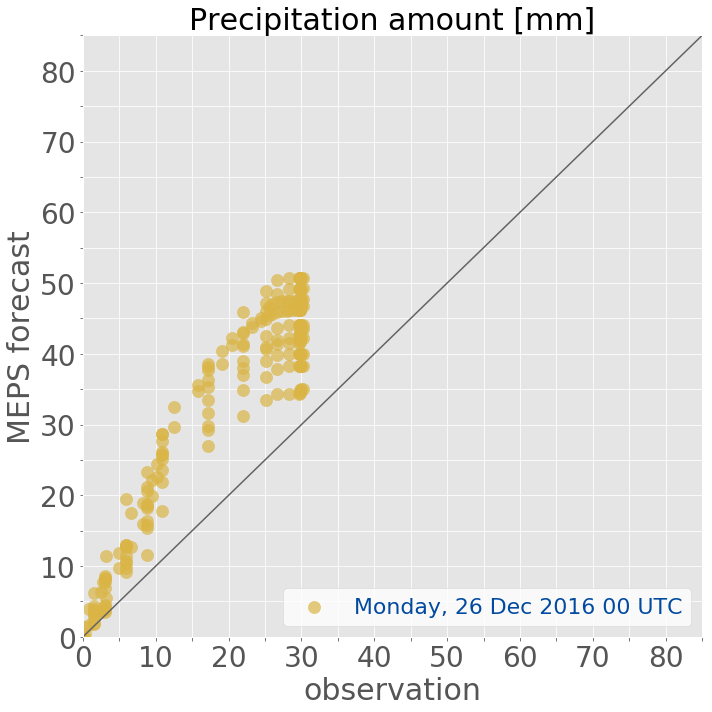

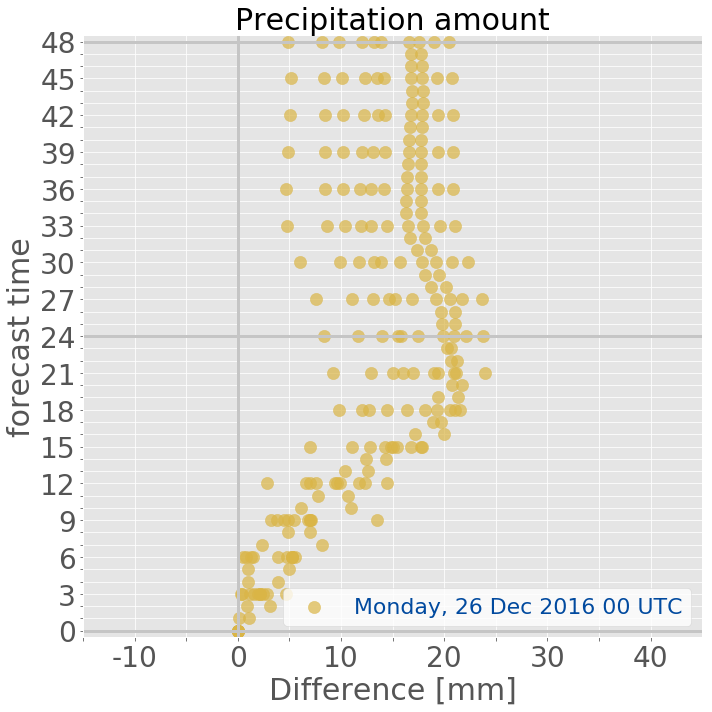

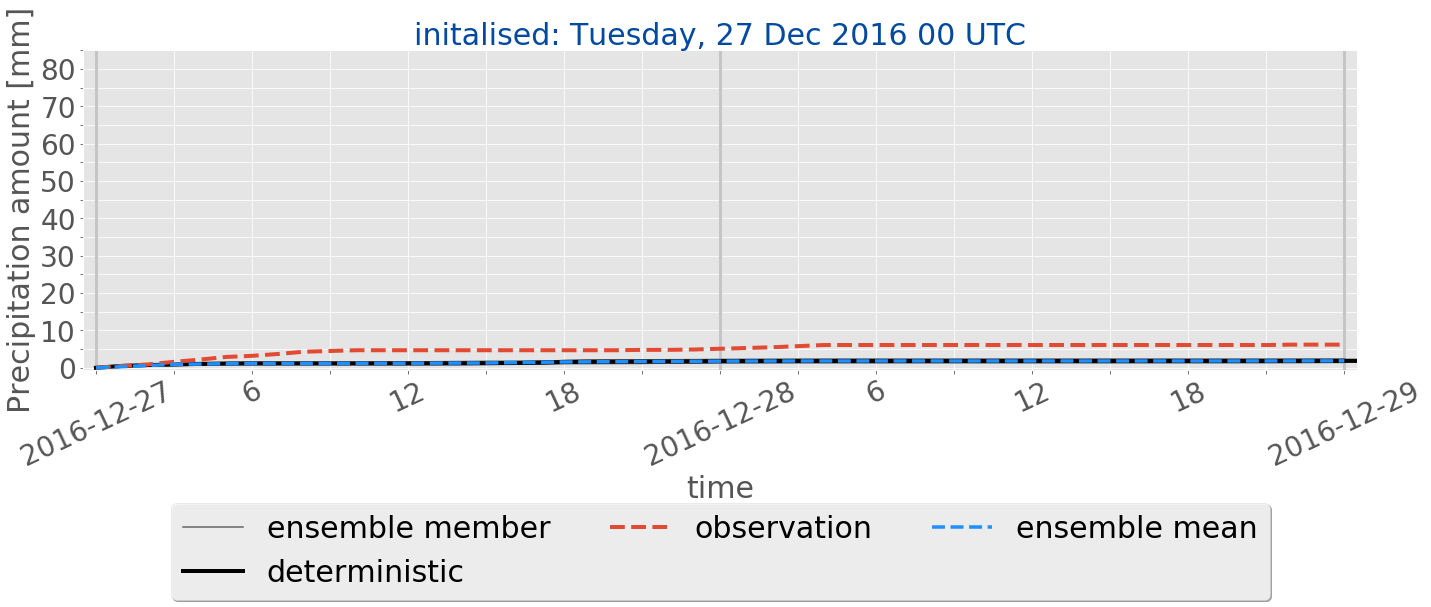

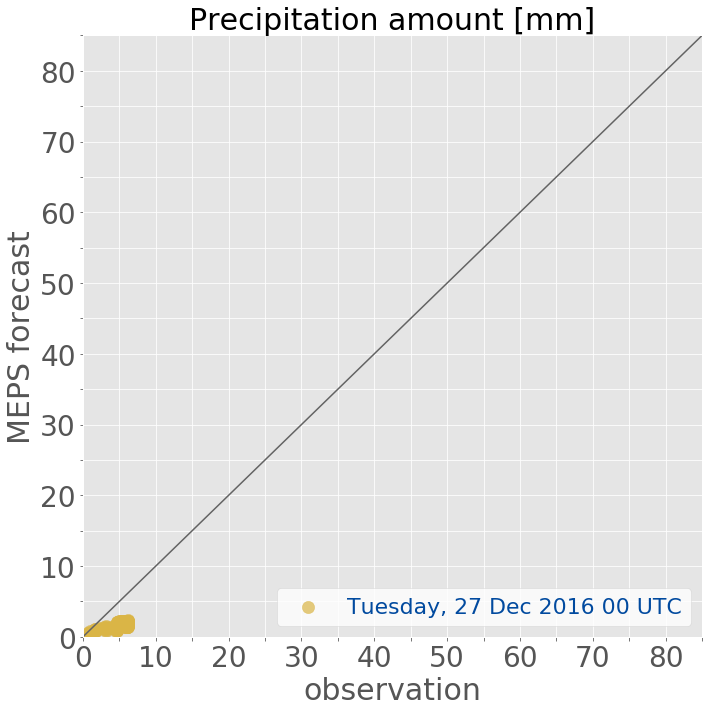

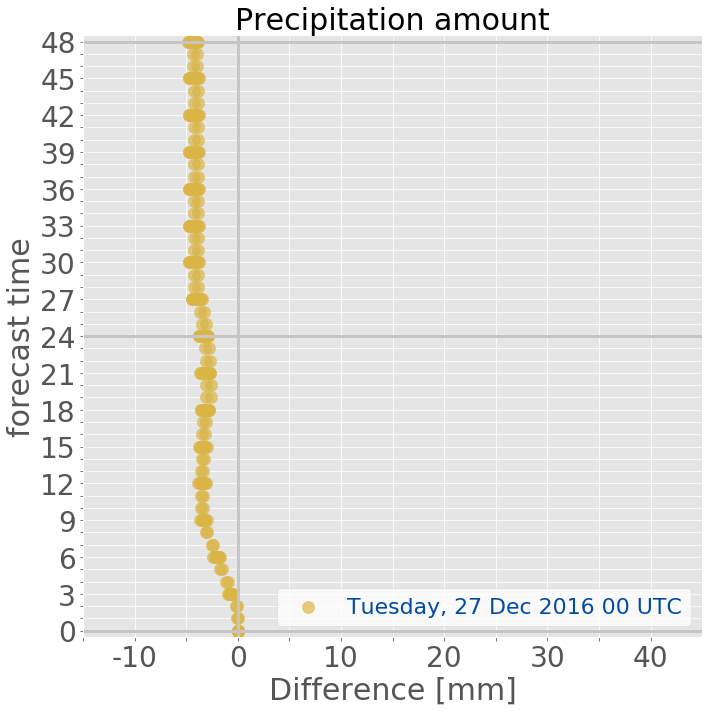

In [12]:
#t = ['24']
for day in t:
    
    if var == 'T2' or var == 'SP' or var == 'WD' or var == 'WS':
        ### connect variable data for two days
        df1 = obsvar0[int(day)-1]
        df2 = obsvar0[int(day)]
        Variable_obs = np.concatenate((df1,df2),axis=0)
        df3 = obsvar0[int(day)+1][0]
        Variable_obs = np.append(Variable_obs,df3)
    



    
    
    for ens_memb in range(0,10):
        fn_var[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_var,year,month,day,tid,ens_memb))
        
        time_var[ens_memb] = fn_var[ens_memb].variables['time']
        time_var[ens_memb] = fv.fill_nan(time_var[ens_memb][:])
        lead_time_var[ens_memb] = np.arange(0,time_var[ens_memb].shape[0])
# initialisation time for plotting
        ini_day = (datetime.datetime.utcfromtimestamp(time_var[0][0]).day)   # day of initialisation
        hh = (datetime.datetime.utcfromtimestamp(time_var[0][0]).hour)       # first hour of initialisation
        calday, calmon = cd.get_dayname(year, month, ini_day)        
# Read in the variable   
        if var == 'PP' or var == 'T2' or var == 'SP':
            model_var[ens_memb] = fn_var[ens_memb].variables[var_name][:]
            if var == 'T2':
                model_var[ens_memb] = model_var[ens_memb]-273.15
            elif var == 'SP':
                model_var[ens_memb] = model_var[ens_memb]/100
            #substitute missing values with nan 
            model_var[ens_memb] = fv.fill_nan(model_var[ens_memb][:])

          

        elif var == 'WD' or var == 'WS':
            model_var_x[ens_memb] = fn_var[ens_memb].variables['x_wind_10m'][:]
            model_var_y[ens_memb] = fn_var[ens_memb].variables['y_wind_10m'][:]
            #substitute missing values with nan 
            model_var_x[ens_memb] = fv.fill_nan(model_var_x[ens_memb][:,:])
            model_var_y[ens_memb] = fv.fill_nan(model_var_y[ens_memb][:,:])


            #### calculate wind direction / speed
            if var == 'WD':
                model_var[ens_memb] = np.arctan2(model_var_y[ens_memb][:,0], model_var_x[ens_memb][:,0])
                model_var[ens_memb] = 270-np.rad2deg(model_var[ens_memb])  # convert from math to meteo direction and to degrees
                larger360 = np.where(model_var[ens_memb] >360.)
                model_var[ens_memb][larger360] = model_var[ens_memb][larger360]-360
            elif var == 'WS':
                model_var[ens_memb] = np.sqrt((model_var_x[ens_memb][:,0])**2 + (model_var_y[ens_memb][:,0])**2) 

#### calculate every 60 min the accumulation over 48 hours
    if var == 'PP':
        Variable_obs = acc.accumulation_dt60_for48h(obsvar0, ini_day)
################

#### calculate the ensemble mean of variable every 3 hours (all 10 ensemble member averaged)
    val = np.zeros(shape=(10,np.asarray(model_var[0])[::3].shape[0]))
    model_var_std = []
    model_var_mean = []
    for ens_memb in range(0,10):
        if var == 'PP' or var == 'T2' or var == 'SP':
            val[ens_memb] = np.asarray(model_var[ens_memb])[::3,0]
        elif var == 'WD' or var == 'WS':
            val[ens_memb] = np.asarray(model_var[ens_memb])[::3]
          
    ### std, mean
    model_var_std.append(np.nanstd(val,axis=0,ddof=1))
    model_var_mean.append(np.mean(val,axis=0))
    
    time_EM_mean = lead_time_var[0][0:np.asarray(model_var[0]).shape[0]:3]

#    time_model_var_mean = lead_time_var[0][~np.isnan(model_var_mean).any(axis=0)]
 #   model_var_mean = np.asarray(model_var_mean)[~np.isnan(model_var_mean)]
################    

### save calendar day etc. for scatter plot
    calendar_day.append(calday)
    initialisation_day.append(ini_day)
    calendar_month.append(calmon)
    calendar_year.append(year)
    initialisation_hh.append(hh) 
########


#### calculate the difference between obs and model
    diff_var, Diff_var_0, \
        Diff_var_1, Diff_var_2, Diff_var_3, \
        Diff_var_4, Diff_var_5, Diff_var_6, \
        Diff_var_7, Diff_var_8, Diff_var_9  = calc_diff(diff_var, \
                                                       model_var, Variable_obs, Diff_var_0,\
                                                       Diff_var_1, Diff_var_2, Diff_var_3, \
                                                       Diff_var_4, Diff_var_5, Diff_var_6, \
                                                       Diff_var_7, Diff_var_8, Diff_var_9,var=var)

    if var == 'WD':
        for ens_memb in range(0,10):
            if (diff_var[ens_memb] < -180).any() == True:
                diff_var[ens_memb][np.where(diff_var[ens_memb] < -180)] = \
                diff_var[ens_memb][np.where(diff_var[ens_memb] < -180)]+360
                
            elif (diff_var[ens_memb] > 180).any() == True:
                diff_var[ens_memb][np.where(diff_var[ens_memb] > 180)] = \
                    diff_var[ens_memb][np.where(diff_var[ens_memb] > 180)]-360

#########################################
### save daily variable
    if var == 'PP' or var == 'T2' or var == 'SP':
        model_var_0.append(model_var[0][:,0])
        model_var_1.append(model_var[1][:,0])
        model_var_2.append(model_var[2][:,0])
        model_var_3.append(model_var[3][:,0])
        model_var_4.append(model_var[4][:,0])
        model_var_5.append(model_var[5][:,0])
        model_var_6.append(model_var[6][:,0])
        model_var_7.append(model_var[7][:,0])
        model_var_8.append(model_var[8][:,0])
        model_var_9.append(model_var[9][:,0])
    elif var == 'WD' or var == 'WS':
        model_var_0.append(model_var[0])#[:,0])
        model_var_1.append(model_var[1])#[:,0])
        model_var_2.append(model_var[2])#[:,0])
        model_var_3.append(model_var[3])#[:,0])
        model_var_4.append(model_var[4])#[:,0])
        model_var_5.append(model_var[5])#[:,0])
        model_var_6.append(model_var[6])#[:,0])
        model_var_7.append(model_var[7])#[:,0])
        model_var_8.append(model_var[8])#[:,0])
        model_var_9.append(model_var[9])#[:,0])
    
    obs_var.append(Variable_obs)
    
#########################################    
    if hh < 10:
        hh = '0%s' %hh
    else:
        hh = hh
#########################################
    for ens_memb in range(0,10):
        if var == 'PP' or var == 'T2' or var == 'SP':
            lead_time_var[ens_memb] = lead_time_var[ens_memb][~np.isnan(model_var[ens_memb][:,0])]
        elif var == 'WD' or var == 'WS':
            lead_time_var[ens_memb] = lead_time_var[ens_memb][~np.isnan(model_var[ens_memb])]
        model_var[ens_memb]     = model_var[ens_memb][~np.isnan(model_var[ens_memb])]
    
    
    
        fn_var[ens_memb].close()
###########

        
        
        

##### PLOTTING ############################################
    fig_name = '%s%s%s_%s.png' %(year,month,ini_day,hh)
    
    title = 'initalised: %s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    xdays = ['%s-%s-%s' %(year,month,ini_day), '',
        6,'',12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+1), '',
        6,'', 12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+2)]
####### plot variable    
    lgd = plt_variable(lead_time_var,model_var,Variable_obs,time_EM_mean, np.asarray(model_var_mean)[0,:],var=var,
                       xdays=xdays, title = title)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir_var, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir_var,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

###################################################################    
#### plot scatter observation vs. model
    if day == '20':
        cc = no1
    elif day == '21':
        cc = no2
    elif day == '22':
        cc = no3
    elif day == '23':
        cc = no4
    elif day == '24':
        cc = no5
    elif day == '25':
        cc = no6
    elif day == '26':
        cc = no7
    label = '%s, %s %s %s %s UTC' %(calday,ini_day, 
                                        calmon,year,hh)
    plt_scatter_obs_model(Variable_obs, model_var,cc,var=var,label=label)  
    if savefig == 1:
        plt.savefig('%s/obs_model_%s' % (figdir_scatter, fig_name))
        print('plot saved: %s/obs_model_%s' %(figdir_scatter,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()
     

###################################################################    
#### plot scatter difference
 
    
    plt_scatter_diff(diff_var, lead_time_var, Variable_obs, cc, var=var,label=label)
    if savefig == 1:
        plt.savefig('%s/diff_%s' % (figdir_scatter, fig_name))
        print('plot saved: %s/diff_%s' %(figdir_scatter,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

In [13]:
###################################
model_var_all_day = dict()

model_var_all_day[0]=(model_var_0)
model_var_all_day[1]=(model_var_1)
model_var_all_day[2]=(model_var_2)
model_var_all_day[3]=(model_var_3)
model_var_all_day[4]=(model_var_4)
model_var_all_day[5]=(model_var_5)
model_var_all_day[6]=(model_var_6)
model_var_all_day[7]=(model_var_7)
model_var_all_day[8]=(model_var_8)
model_var_all_day[9]=(model_var_9)

In [14]:
model_2124 = []
obs_var_2124 = []
for ens_memb in range(0,10):
    model_2124.append(np.asarray(model_var_all_day[ens_memb])[1:4,:np.asarray(obs_var)[1:4,:].shape[0]])
    obs_var_2124.append(np.asarray(obs_var)[1:4,:np.asarray(obs_var)[1:4,:np.asarray(obs_var)[1:4,:].shape[0]].shape[0]])

In [15]:
from scipy import stats

def regression_all_EM(model_var_all_day,obs_var,day):
    model_2112 = []
    obs_var_2112 = []
    for ens_memb in range(0,10):
        model_2112.append(np.asarray(model_var_all_day[ens_memb])[day,:np.asarray(obs_var)[day,:].shape[0]])
        obs_var_2112.append(np.asarray(obs_var)[day,:np.asarray(obs_var)[day,:].shape[0]])


#    print(np.asarray(obs_var_2112).shape)
 #   print(np.asarray(model_2112).shape)
    PP_obs_flat_21 = np.ndarray.flatten(np.asarray(obs_var_2112))
    PP_model_flat_21 = np.ndarray.flatten(np.asarray(model_2112))

    x_obs = np.asarray(PP_obs_flat_21)
    y_obs = np.asarray(PP_model_flat_21)
    mask_obs = ~np.isnan(x_obs) & ~np.isnan(y_obs)
    gradient_obs, intercept_obs, r_value, p_value, std_err = stats.linregress(x_obs[mask_obs],y_obs[mask_obs])

    return(PP_obs_flat_21,PP_model_flat_21,x_obs,gradient_obs,intercept_obs, r_value, p_value, std_err)

In [16]:
PP_obs_flat = dict()
PP_model_flat = dict()
x_obs = dict()
gradient_obs = dict()
intercept_obs = dict()
r_value = dict()
p_value = dict()
std_err = dict()


for day in range(0,len(obs_var)):
#    print(day)
    PP_obs_flat[day],PP_model_flat[day],x_obs[day],gradient_obs[day],intercept_obs[day], r_value[day], p_value[day], std_err[day] \
        = regression_all_EM(model_var_all_day,obs_var,day)


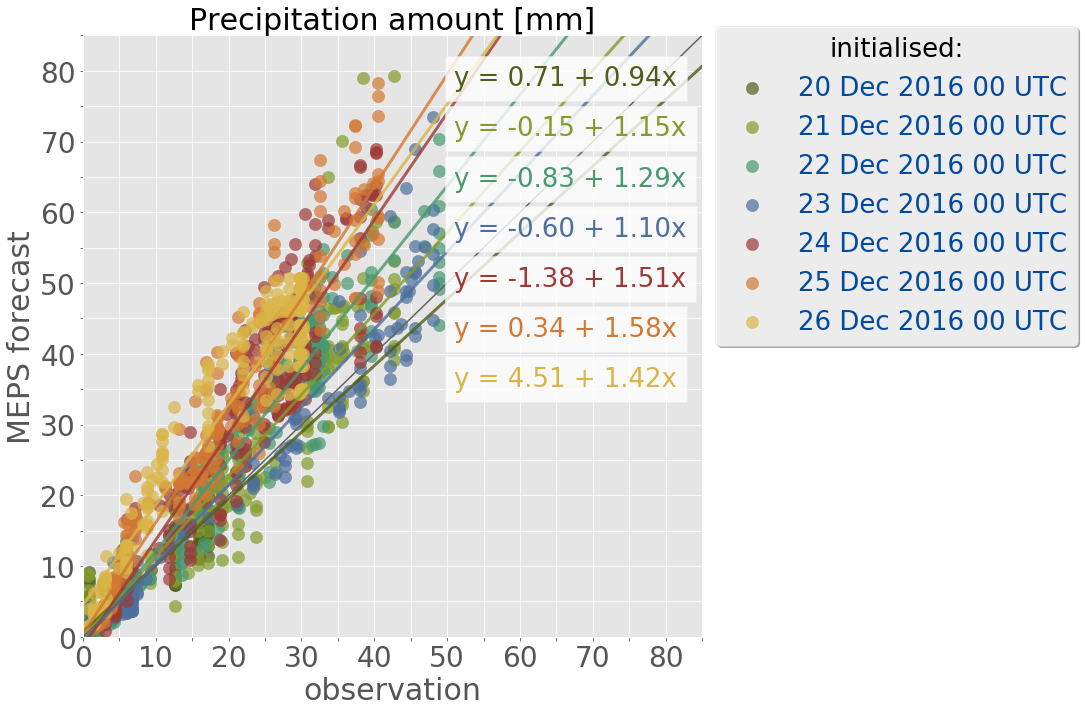

In [17]:
###################################################################    
#### plot scatter observation vs. model
lgd = plt_scatter_all_days(obs_var,model_var_all_day,var=var, day_range=np.arange(0,len(obs_var)-1),
                               in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh,
                          x_obs=x_obs,intercept_obs=intercept_obs,gradient_obs=gradient_obs)
fig_name = 'obs_model_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

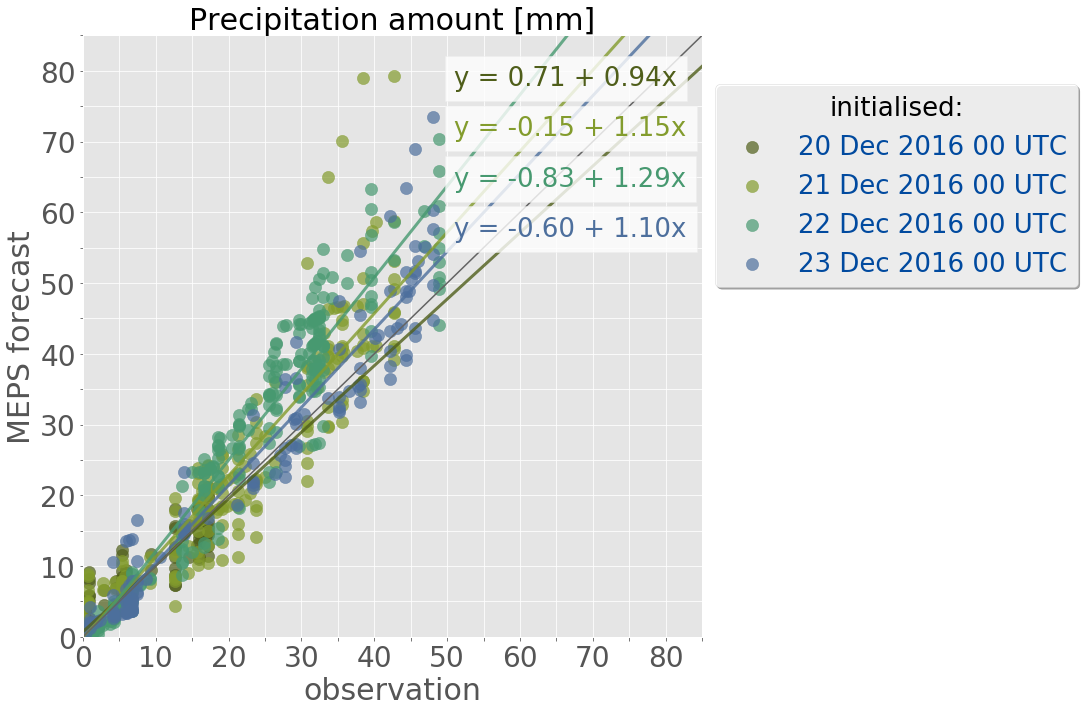

In [18]:
### 20.12. - 23.12. 
lgd = plt_scatter_all_days(obs_var,model_var_all_day,var=var, day_range=np.arange(0,4),
                               in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh,
                          x_obs=x_obs,intercept_obs=intercept_obs,gradient_obs=gradient_obs)
fig_name = 'obs_model_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[4-1],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

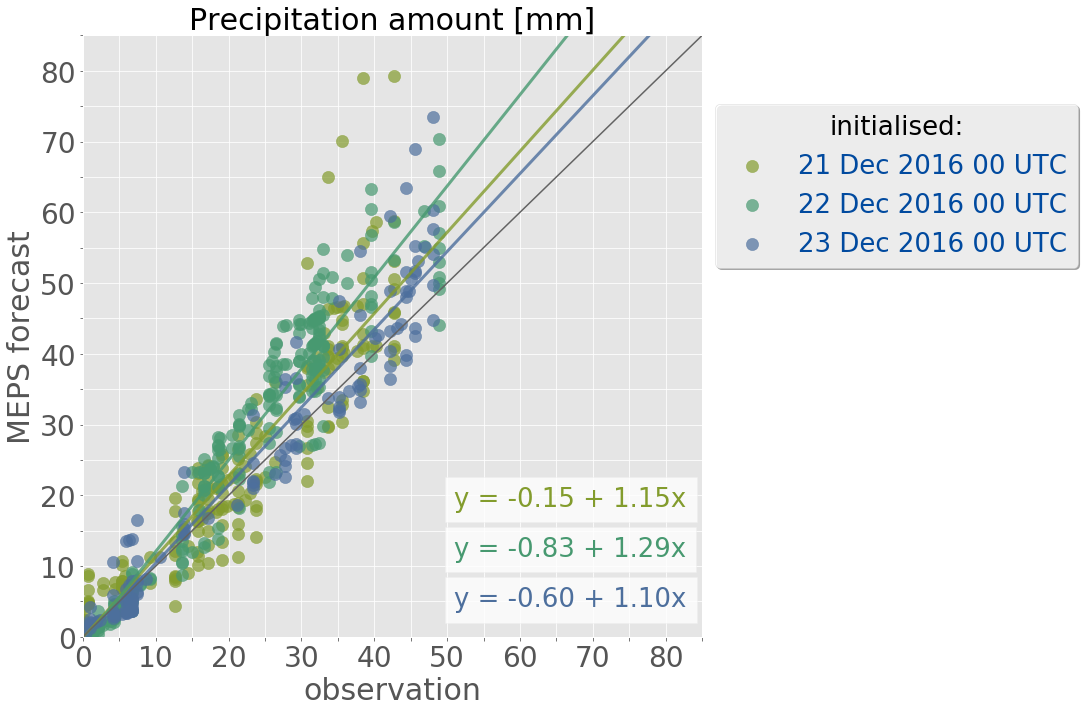

In [19]:
### 21.12. - 23.12. 
lgd = plt_scatter_all_days(obs_var,model_var_all_day,var=var, day_range=np.arange(1,4),
                               in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh,
                          x_obs=x_obs,intercept_obs=intercept_obs,gradient_obs=gradient_obs)
fig_name = 'obs_model_%s%s%s_%s_%s.png' %(calendar_year[1],month,initialisation_day[1],initialisation_day[4-1],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

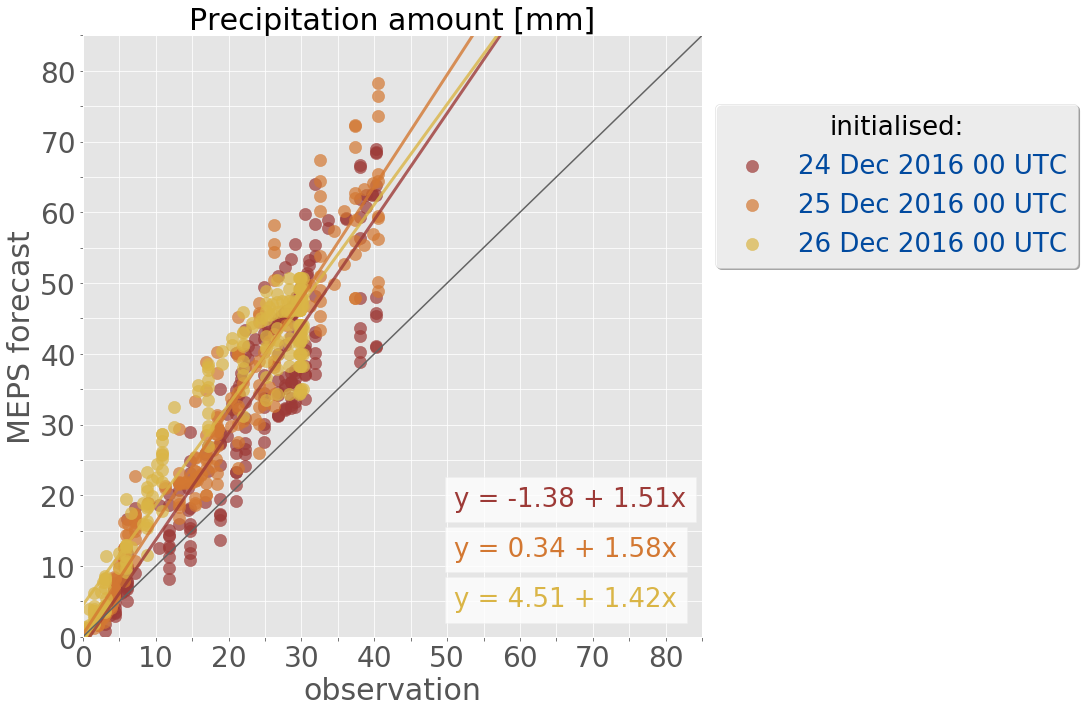

In [20]:
### 24.12. - 26.12.
lgd = plt_scatter_all_days(obs_var,model_var_all_day,var=var, day_range=np.arange(4,len(obs_var)-1),
                               in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh,
                          x_obs=x_obs,intercept_obs=intercept_obs,gradient_obs=gradient_obs)
fig_name = 'obs_model_%s%s%s_%s_%s.png' %(calendar_year[4],month,initialisation_day[4],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

In [21]:
###################################################################    
#### plot scatter difference
Diff_obs_model_var = dict()

Diff_obs_model_var[0]=(Diff_var_0)
Diff_obs_model_var[1]=(Diff_var_1)
Diff_obs_model_var[2]=(Diff_var_2)
Diff_obs_model_var[3]=(Diff_var_3)
Diff_obs_model_var[4]=(Diff_var_4)
Diff_obs_model_var[5]=(Diff_var_5)
Diff_obs_model_var[6]=(Diff_var_6)
Diff_obs_model_var[7]=(Diff_var_7)
Diff_obs_model_var[8]=(Diff_var_8)
Diff_obs_model_var[9]=(Diff_var_9)

In [22]:
pd.DataFrame(Diff_obs_model_var[0])

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.0,0.006838,-0.091220,-0.091106,-0.090452,-0.084056,-0.074966,-0.071424,-0.060512,0.011340,...,2.981927,3.490610,2.473331,2.703717,1.326859,2.336804,2.249796,1.762735,2.964212,2.852994
1,0.0,0.000410,0.000810,0.001219,0.001396,0.002293,0.016144,0.099449,0.151997,0.416180,...,4.354672,4.058693,4.446588,4.108984,4.260614,2.820456,2.280579,1.335095,0.840115,-1.626117
2,0.0,-0.813738,-0.736645,-0.594421,-1.060758,-1.854099,-0.967847,-1.324777,-0.904450,-0.133193,...,12.737840,12.794084,13.797243,15.042290,16.688290,17.809445,17.219254,15.867123,13.361835,11.998849
3,0.0,-0.165257,0.355883,1.034084,0.326209,0.137923,-1.442804,-1.461481,-2.127715,-2.584311,...,1.157980,0.565146,0.478314,3.712375,4.181424,5.519073,6.160315,7.093155,8.232950,9.605414
4,0.0,-2.210934,-0.010534,1.518602,0.961989,0.715291,1.092381,1.961665,2.123293,3.316177,...,19.405533,20.741437,22.297211,23.542398,25.171567,22.963370,21.277542,21.985645,22.915540,28.383603
5,0.0,0.700485,0.561283,0.523170,0.650443,0.953394,0.822733,0.945982,1.279569,1.258537,...,12.769925,16.132715,15.550885,16.456955,15.379929,16.828586,16.706033,16.742621,17.133884,18.709625
6,0.0,0.116152,0.876754,1.543339,0.995119,1.028091,1.495449,2.343941,4.833528,4.866674,...,17.757693,17.771991,17.812686,17.877078,17.913776,17.923557,17.831552,17.848535,17.764542,17.576855
7,0.0,0.003709,-0.165154,-0.735891,-1.152524,-1.741103,-2.022948,-2.520866,-3.120450,-3.320732,...,-4.270883,-4.270799,-4.270776,-4.270753,-4.270845,-4.270227,-4.270586,-4.367618,-4.365268,-4.360522


In [87]:
avg_perc = []

In [94]:

diff_perc = []

for i in range(6,7):
    print(np.asarray(obs_var)[i,24])
    for ens_memb in range(0,10):
        print('model %s' %ens_memb,np.asarray(model_var_all_day[ens_memb])[i,24])
        print('Diff [perc], %s' %ens_memb, 
              (np.asarray(model_var_all_day[ens_memb])[i,24]-np.asarray(obs_var)[i,24])/np.asarray(obs_var)[i,24]*100)
              #(np.asarray(Diff_obs_model_var[ens_memb])[i,24]/np.asarray(obs_var)[i,24])*100)
        diff_perc.append((np.asarray(Diff_obs_model_var[ens_memb])[i,24]/np.asarray(obs_var)[i,24])*100)
    print('Avg [perc]', np.nanmean(diff_perc))
    avg_perc.append(np.nanmean(diff_perc))
#print(np.nanmean(avg_perc))

25.1
model 0 46.1025
Diff [perc], 0 83.6753936403
model 1 44.9541
Diff [perc], 1 79.1001886011
model 2 39.0479
Diff [perc], 2 55.569372899
model 3 47.2309
Diff [perc], 3 88.1709003828
model 4 40.9046
Diff [perc], 4 62.966481243
model 5 40.6411
Diff [perc], 5 61.9166036051
model 6 36.767
Diff [perc], 6 46.4820649044
model 7 48.8542
Diff [perc], 7 94.6383776418
model 8 33.4594
Diff [perc], 8 33.3042463933
model 9 42.5662
Diff [perc], 9 69.5864856006
Avg [perc] 67.5410114911


In [98]:
np.nanmean(np.asarray(avg_perc)[4:7])

54.398281291471498

In [33]:
np.asarray(Diff_obs_model_var[0])[:,12]/np.asarray(obs_var)[:,12]*100

[  0.1   0.7  13.6   6.3  14.7   4.3   8.8   4.7]
[ 0.33683815  4.31342773  2.01392593 -2.62886505  3.56554871  2.43738098
  9.41274567 -3.5194809 ]


array([ 336.83815002,  616.20396205,   14.80827893,  -41.72801669,
         24.25543337,   56.68327864,  106.96301894,  -74.88257226])

In [ ]:
lgd = plt_all_day_diff(Diff_obs_model_var,lead_time_var,Variable_obs,var,np.arange(0,len(Diff_obs_model_var[0])-1),
                      in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()


### 20.12. - 23.12. 
lgd = plt_all_day_diff(Diff_obs_model_var,lead_time_var,Variable_obs,var,np.arange(0,4),
                      in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[4-1],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

### 21.12. - 23.12. 
lgd = plt_all_day_diff(Diff_obs_model_var,lead_time_var,Variable_obs,var,np.arange(1,4),
                      in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[1],month,initialisation_day[1],initialisation_day[4-1],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

### 24.12. - 26.12.
lgd = plt_all_day_diff(Diff_obs_model_var,lead_time_var,Variable_obs,var,np.arange(4,len(Diff_obs_model_var[0])-1),
                      in_day=initialisation_day, cal_mon=calendar_month,
                              cal_year=calendar_year,in_hh=initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[4],month,initialisation_day[4],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

In [ ]:
def mean_abs_error(Diff_obs_model_var,ens_memb,start_hour,end_hour):
    MAE_0 = []
    ME_0 = []
    for day in range(0,len(Diff_obs_model_var[ens_memb])):
        ME_0.append(np.nanmean((np.asarray(Diff_obs_model_var[ens_memb])[day,start_hour:end_hour])))
        MAE_0.append( np.nanmean(np.abs(np.asarray(Diff_obs_model_var[ens_memb])[day,start_hour:end_hour])))
    return(MAE_0, ME_0)
MAE = dict()
ME = dict()
MAE_12 = dict()
ME_12 = dict()
MAE_12_24 = dict()
ME_12_24 = dict()
for ens_memb in range(0,10):
    MAE[ens_memb], ME[ens_memb] = mean_abs_error(Diff_obs_model_var,ens_memb,
                                                 0,np.asarray(Diff_obs_model_var[ens_memb]).shape[1])
    if var == 'PP':
        MAE_12[ens_memb], ME_12[ens_memb] = mean_abs_error(Diff_obs_model_var,ens_memb,
                                                 0,12)
        MAE_12_24[ens_memb], ME_12_24[ens_memb] = mean_abs_error(Diff_obs_model_var,ens_memb,
                                                 12,24)

In [ ]:
def plt_mean_abs_error(MAE,var):
    
    ### plot mean absolute error
    fig = plt.figure(figsize=(20,7))
    ax = fig.add_subplot(111)

    ax.plot(MAE[0][:7],'k', linewidth=4, label = 'deterministic')
    ax.plot(MAE[1][:7],color = spagh.memb_col, linestyle='-', label = 'ensemble member')
    for ens_memb in range(2,10):
        ax.plot(MAE[ens_memb][:7],color = spagh.memb_col, linestyle='-', label = '_nolegend_')

    ### fine tuning
    lgd = ax.legend(loc='upper center', #bbox_to_anchor=(0.5, -0.37),
              fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')

    # xaxis
    ax.set_xlim(-0.25,6.25)
    ax.set_xlabel('Dec 2016', fontsize=spagh.label_fs)
    ax.set_xticks(np.arange(0,7))
    ax.set_xticklabels([20, 21, 22, 23, 24, 25, 26], fontsize=spagh.tick_fs)

    ax.axhline(0, color=spagh.vert_col, linewidth=3)
    #ax.axvline(1, color=spagh.vert_col, linewidth=3)
    #ax.axvline(2, color=spagh.vert_col, linewidth=3)
    #ax.axvline(3, color=spagh.vert_col, linewidth=3)
    #ax.axvline(4, color=spagh.vert_col, linewidth=3)
    #ax.axvline(5, color=spagh.vert_col, linewidth=3)
    #ax.axvline(6, color=spagh.vert_col, linewidth=3)



    if var == 'PP':
        # yaxis
        ax.set_ylim(-0.25, 25)
        ax.set_yticks(np.arange(0,27.5,2.5))
        ax.set_yticklabels([0, '',  5,'',10,'',15,'',20,'',25], fontsize=spagh.tick_fs)
        ax.set_title('Precipitation amount (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Absolute Error [mm]', fontsize=spagh.label_fs)
    elif var ==  'SP':
        # yaxis
        ax.set_ylim(-0.25, 3)
        ax.set_yticks(np.arange(0,3.5,.25))
        ax.set_yticklabels([0, '', 0.5 ,'',1.0,'',1.5,'',2.0,'',2.5,'',3,''], fontsize=spagh.tick_fs)
        ax.set_title('Sea Level Pressure (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Absolute Error [hPa]', fontsize=spagh.label_fs)
    elif var == 'T2':
        # yaxis
        ax.set_ylim(-0.25, 2.5)
        ax.set_yticks(np.arange(0,2.75,.25))
        ax.set_yticklabels([0, '', 0.5 ,'',1.0,'',1.5,'',2.0,'',2.5,'',3,''], fontsize=spagh.tick_fs)
        ax.set_title('Air Temperature (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Absolute Error [K]', fontsize=spagh.label_fs)
    elif var == 'WD':
        # yaxis 
        ax.set_ylim(-0.25,45)
        ax.set_yticks(np.arange(0,50,5))
        ax.set_yticklabels([0, '',10,'',20,'',30,'',40,'',50], fontsize=spagh.tick_fs)
        ax.set_title('Wind direction (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Absolute Error [$^\circ$]', fontsize=spagh.label_fs)
    elif var == 'WS':
        # yaxis
        ax.set_ylim(-.25,8.5)
        ax.set_yticks(np.arange(0,9,0.5))
        ax.set_yticklabels([0, '',1,'',2,'',3,'',4,'', 5 ,'',6,'',7,'',8,'',9], fontsize=spagh.tick_fs)
        ax.set_title('Wind speed (00+48)', fontsize=spagh.fontsize) 
        ax.set_ylabel('Mean Absolute Error [m$\,$s$^{-1}$]', fontsize=spagh.label_fs)

    plt.tight_layout()

In [ ]:
plt_mean_abs_error(MAE,var)
fig_name = 'MAE_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_error,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

In [ ]:
if var == 'PP':
    plt_mean_abs_error(MAE_12,var)
    fig_name = 'MAE12_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir_error,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

    plt_mean_abs_error(MAE_12_24,var)
    fig_name = 'MAE12_24_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir_error,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

In [ ]:
for day in range(0,1):
    for ens_memb in range(0,10):
        print('2%s Dec' %day,'MAE: %s' %ens_memb, MAE[ens_memb][day])

In [ ]:
def plt_mean_error(ME,var):
    ### plot mean error
    fig = plt.figure(figsize=(20,7))
    ax = fig.add_subplot(111)

    ax.plot(ME[0][:7],'k', linewidth=4, label = 'deterministic')
    ax.plot(ME[1][:7],color = spagh.memb_col, linestyle='-', label = 'ensemble member')
    for ens_memb in range(2,10):
        ax.plot(ME[ens_memb][:7],color = spagh.memb_col, linestyle='-', label = '_nolegend_')

    ### fine tuning
    lgd = ax.legend(loc='upper center', #bbox_to_anchor=(0.5, -0.37),
              fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')

    # xaxis
    ax.set_xlim(-0.25,6.25)
    ax.set_xlabel('Dec 2016', fontsize=spagh.label_fs)
    ax.set_xticks(np.arange(0,7))
    ax.set_xticklabels([20, 21, 22, 23, 24, 25, 26], fontsize=spagh.tick_fs)

    ax.axhline(0, color=spagh.vert_col, linewidth=3)



    if var == 'PP':
        # yaxis
        ax.set_ylim(0, 25)
        ax.set_yticks(np.arange(-5,27.5,2.5))
        ax.set_yticklabels([-5, '',0, '',  5,'',10,'',15,'',20,'',25], fontsize=spagh.tick_fs)
        ax.set_title('Precipitation amount (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Error [mm]', fontsize=spagh.label_fs)
    elif var ==  'SP':
        # yaxis
        ax.set_ylim(-0.25, 3)
        ax.set_yticks(np.arange(0,3.5,.25))
        ax.set_yticklabels([0, '', 0.5 ,'',1.0,'',1.5,'',2.0,'',2.5,'',3,''], fontsize=spagh.tick_fs)
        ax.set_title('Sea Level Pressure (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Error [hPa]', fontsize=spagh.label_fs)
    elif var == 'T2':
        # yaxis
        ax.set_ylim(-2., 1)
        ax.set_yticks(np.arange(-2,1.75,.25))
        ax.set_yticklabels([-2,'',-1.5,'',-1,'',-0.5 ,'',0, '', 0.5 ,'',1.0,'',1.5,'',2.0,'',2.5,'',3,''], fontsize=spagh.tick_fs)
        ax.set_title('Air Temperature (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Error [K]', fontsize=spagh.label_fs)
    elif var == 'WD':
        # yaxis 
        ax.set_ylim(-17.5,20)
        ax.set_yticks(np.arange(-20,22.5,2.5))
        ax.set_yticklabels([-20,'',-15,'',-10,'',-5 ,'',0, '', 5 ,'',10,'',15,'',20,'',25,'',30,''], fontsize=spagh.tick_fs)
        ax.set_title('Wind direction (00+48)', fontsize=spagh.fontsize)
        ax.set_ylabel('Mean Error [$^\circ$]', fontsize=spagh.label_fs)
    elif var == 'WS':
        # yaxis
        ax.set_ylim(-.25,8.5)
        ax.set_yticks(np.arange(0,9,0.5))
        ax.set_yticklabels([0, '',1,'',2,'',3,'',4,'', 5 ,'',6,'',7,'',8,'',9], fontsize=spagh.tick_fs)
        ax.set_title('Wind speed (00+48)', fontsize=spagh.fontsize) 
        ax.set_ylabel('Mean Error [m$\,$s$^{-1}$]', fontsize=spagh.label_fs)

    plt.tight_layout()

In [ ]:
plt_mean_error(ME,var)
fig_name = 'ME_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_error,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

In [ ]:
if var == 'PP':
    plt_mean_error(ME_12,var)
    fig_name = 'ME12_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir_error,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

    plt_mean_error(ME_12_24,var)
    fig_name = 'ME12_24_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir_error, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir_error,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

In [ ]:
for ens_memb in range(0,10):
    print('%s' %ens_memb, MAE_12[ens_memb][5])